In [1]:
import random
import matplotlib.pyplot as plt
import gnwrapper
import gymnasium as gym 
import numpy as np
from IPython.display import clear_output

In [2]:
env = gnwrapper.LoopAnimation(gym.make('CartPole-v1', render_mode="rgb_array"))

#action: ndarray with shape (1,); possible values {0, 1}; left: 0; right: 1
#observation: (xPosition, cartVelocity, poleAngle, poleAngleVelocity)
obs = env.reset()

for _ in range(5):
    while True:
        #random policy
        next_obs, reward, term, trunc, info = env.step(env.action_space.sample())
        env.render()

        obs = next_obs
        if term or trunc:
            obs = env.reset()
            break

env.display()

In [3]:
MAX_ACTIONS = 500
def test_policy(policyFn):
    env = gym.make('CartPole-v1')
    obs, _ = env.reset()

    final_reward = 0
    rewards = []
    for _ in range(1000):
        for i in range(MAX_ACTIONS):
            next_obs, reward, term, trunc, info = env.step(policyFn(obs))
            final_reward += reward

            obs = next_obs
            if term or trunc:
                rewards.append(final_reward)
                final_reward = 0
                obs, _= env.reset()
                break
    return rewards

def plot_rewards(rewards):
    avg = np.mean(rewards)
    plt.plot(rewards)
    plt.axline((0, avg), (1000, avg), color='r')
    plt.title(f'mean reward: {avg}')
    plt.ylabel('Reward')
    plt.xlabel('Iteration')
    plt.show()

### Random sampling

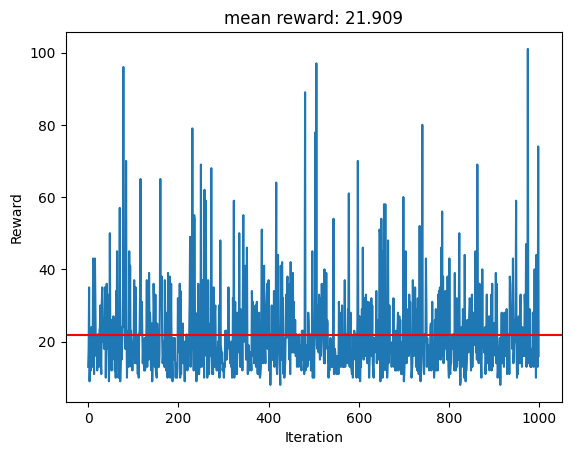

In [4]:
def random_policy(obs):
    return random.randint(0, 1) 

#test random policy
rewards = test_policy(random_policy)
plot_rewards(rewards)

### Angle velocity based policy 

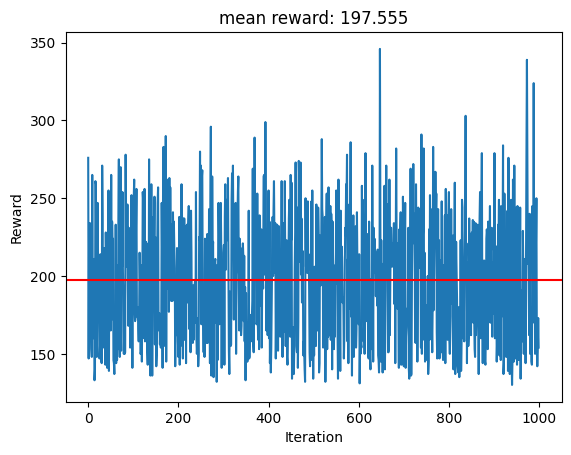

In [5]:
#policy based on angle velocity omega
def omega_policy(obs):
    w = obs[3]
    return 0 if w < 0 else 1

rewards = test_policy(omega_policy)
plot_rewards(rewards)

### Q-Learning
$$ Q(s,a) \leftarrow Q(s,a) + \alpha (R+\gamma Q_{max}-Q(s,a))$$
$$ Q_{max} = max_{a}Q(s',a) $$

Policy: $$ \pi(s, a)=\underset{a}{argmax} \ Q(s,a) $$

In [6]:
env = gym.make('CartPole-v1')

# discretization process for observation space because it is continuous
# subdevide in bins
# cart position, cart velocity, pole angle, and pole angular velocity
numberOfBins = (30, 30, 30, 30)

lowerBounds = env.observation_space.low
upperBounds = env.observation_space.high

# update because space is infinity
lowerBounds[1]=-3
upperBounds[1]=3
lowerBounds[3]=-10
upperBounds[3]=10

Qmatrix=np.random.uniform(low=0, high=1, size=(numberOfBins) + (2,))

bins = [np.linspace(lowerBounds[i], upperBounds[i], numberOfBins[i]) for i in range(len(numberOfBins))]
     
def returnIndexState(state):
    return tuple([np.maximum(np.digitize(state[i], bins[i])-1, 0) for i in range(len(bins))])


Episode 14999
Score: 167.0


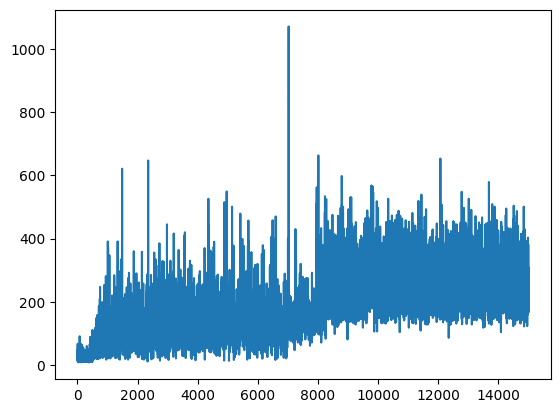

In [7]:
# define the parameters
alpha=0.1
gamma=1
epsilon=0.2
numberEpisodes=15000

# training
scores = []
for indexEpisode in range(numberEpisodes):
    rewardsEpisode=[]
        
    (state,_)=env.reset()
    
    clear_output(wait=False)
    print("Episode {}".format(indexEpisode))
        
    terminalState=False
    action = 0
    while not terminalState:
        stateIndex=returnIndexState(state)
        q = Qmatrix[stateIndex]

        # epsilon decay
        if indexEpisode > 7000:
            epsilon *= 0.999

        if indexEpisode < 500:
            action = env.action_space.sample()
            
        # epsilon-greedy
        elif np.random.random() < epsilon:
            # pull random action
            action = env.action_space.sample()
        else:
            # pull best action
            action = np.argmax(q)

        # perform action
        next_state, reward, terminalState,_,_ = env.step(action)          
            
        rewardsEpisode.append(reward)
            
        # update Q-Table
        qIndex = stateIndex + (action,) 
        qMax = np.max(Qmatrix[tuple(returnIndexState(next_state))])
            
        Qmatrix[qIndex]+=alpha*(reward+gamma*qMax-Qmatrix[qIndex])
        
        state = next_state
    
    reward = np.sum(rewardsEpisode)
    print(f"Score: {reward}")
    scores.append(reward)

plt.plot(scores)
plt.show()


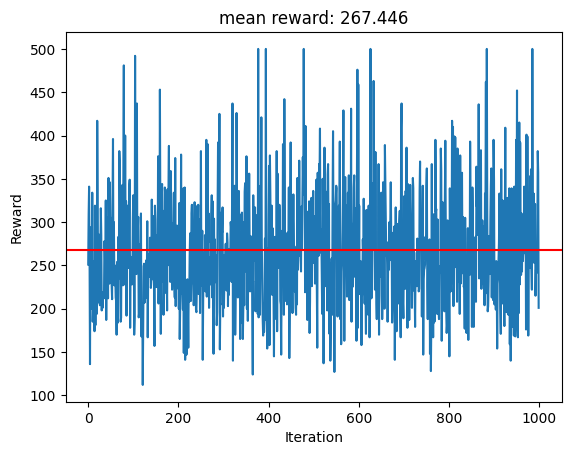

In [8]:
def policy(state):
    return np.argmax(Qmatrix[returnIndexState(state)])

rewards = test_policy(policy)
plot_rewards(rewards)